### Import Packages

In [38]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 1
%matplotlib inline
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_datareader.data as web
import datetime

### Get WTI crude oil daily prices of last 20 years

In [28]:
start_date = datetime.datetime.now() - datetime.timedelta(days=365*20) # 20 years ago
end_date = datetime.datetime.now()

wti = web.DataReader('DCOILWTICO', 'fred', start_date, end_date)
wti=wti.resample('M').mean()
wti=wti.rename({'DCOILWTICO':'WTI'}, axis=1)

In [29]:
wti.isnull().sum()

WTI    0
dtype: int64

Text(0.5, 1.0, 'WTI Crude Oil Monthly Price - USD/bbl')

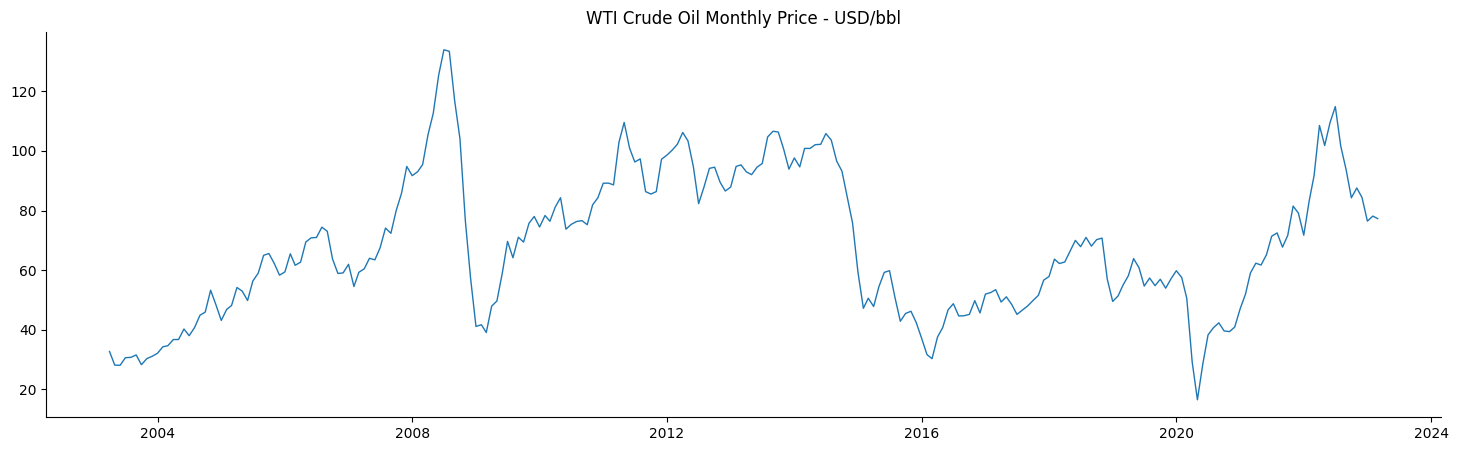

In [42]:
plt.plot(wti)
plt.title('WTI Crude Oil Monthly Price - USD/bbl')

### Check Stationary

1. A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. Whether a TS is stationary is important since
    * Stationary processes are easier to analyze
    * Most forecasting algorithms assume a series is stationary

2. One way to test if a TS is stationary is to plot the rolling mean and rolling standard deviation. If the TS is stationary, then the rolling mean and rolling standard deviation should be constant over time

3. Augmented Dicky-Fuller test, or ADF test is frequently used to determine whether a TS is stationary. It is actually a simple hypothesis testing where
    * Null hypothesis (H0) — Time series is not stationary
    * Alternative hypothesis (H1) — Time series is stationary
    
4. KPSS is another test for stationarity. It is also a hypothesis testing where
    * Null hypothesis (H0) — Time series is stationary
    * Alternative hypothesis (H1) — Time series is not stationary

#### Rolling Statistics

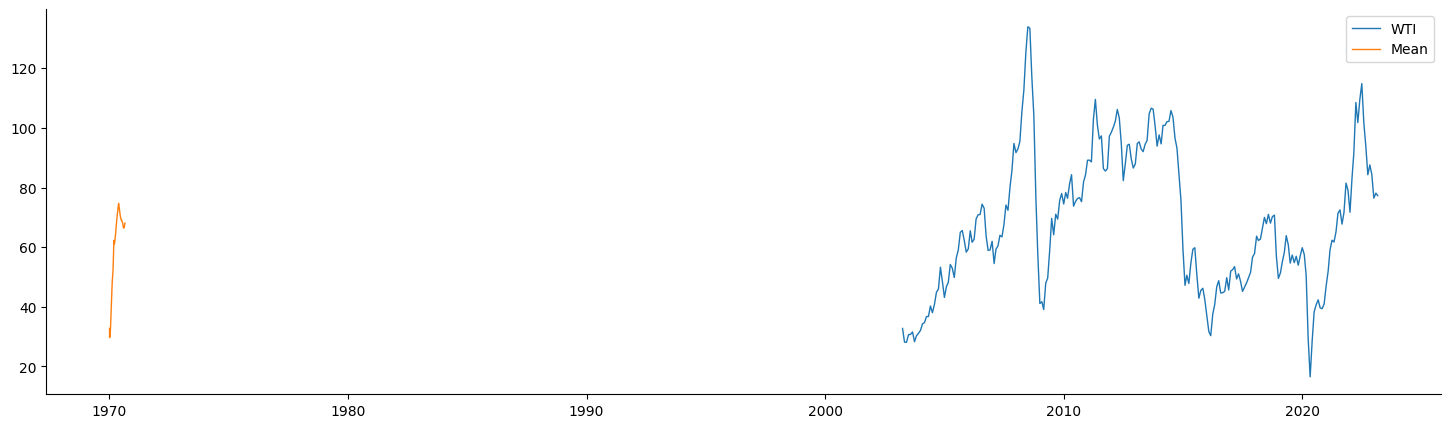

In [44]:
np.random.seed(666)

mean = [np.mean(wti[:i]) for i in range(len(wti))]

plt.plot(wti,label='WTI')
plt.plot(mean,label='Mean')
plt.legend()
plt.show()

In [20]:
def make_stationary(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> dict:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return {
            'differencing_order': 0,
            'time_series': np.array(data)
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        result = adfuller(data.diff(i).dropna())
        # Append P-value
        p_values.append((i, result[1]))
        
    # Keep only those where P-value is lower than significance level
    significant = [p for p in p_values if p[1] < alpha]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = data.diff(diff_order).dropna()
    
    return {
        'differencing_order': diff_order,
        'time_series': np.array(stationary_series)
    }

#### Daily

In [21]:
# Brent Stationary
make_stationary(df['Brent'])

{'differencing_order': 0,
 'time_series': array([34.39, 34.47, 34.94, ..., 81.97, 82.79, 82.14])}

In [22]:
# WTI Stationary
make_stationary(df['WTI'])

{'differencing_order': 0,
 'time_series': array([37.21, 37.76, 37.18, ..., 76.31, 76.31, 76.28])}

#### Monthly

In [24]:
# Brent Stationary
make_stationary(df_monthly['Brent'])

{'differencing_order': 0,
 'time_series': array([ 30.065     ,  25.06772727,  25.85772727,  27.65285714,
         28.34869565,  29.88809524,  27.11227273,  29.60782609,
         28.7525    ,  29.77608696,  31.23636364,  30.8585    ,
         33.63434783,  33.59090909,  37.56761905,  35.18363636,
         38.22136364,  42.74409091,  43.19681818,  49.77666667,
         43.11045455,  39.60217391,  44.31238095,  45.475     ,
         53.07173913,  51.88380952,  48.64545455,  54.35454545,
         57.52      ,  63.98347826,  62.90818182,  58.53857143,
         55.24181818,  56.84136364,  62.77409091,  60.21      ,
         62.06478261,  70.173     ,  69.77695652,  68.55590909,
         73.67428571,  73.23043478,  61.95857143,  57.80818182,
         58.76136364,  62.41952381,  53.74869565,  57.517     ,
         62.05045455,  67.64428571,  67.36478261,  71.04571429,
         76.80863636,  70.76086957,  76.929     ,  82.34      ,
         92.53045455,  90.99      ,  92.13391304,  95.08047619,

In [26]:
# WTI Stationary
make_stationary(df_monthly['WTI'])

{'differencing_order': 0,
 'time_series': array([ 32.99277778,  28.25818182,  28.18272727,  30.66238095,
         30.73869565,  31.57380952,  28.46818182,  30.33826087,
         31.0305    ,  32.20391304,  34.185     ,  34.676     ,
         36.74130435,  36.76772727,  40.25714286,  38.04454545,
         40.66863636,  44.90318182,  45.845     ,  53.28047619,
         48.53      ,  43.11695652,  46.91190476,  48.164     ,
         53.99173913,  52.97904762,  49.91636364,  56.35227273,
         59.00095238,  64.98521739,  65.64681818,  62.26      ,
         58.325     ,  59.35136364,  65.21      ,  61.5375    ,
         62.68521739,  69.448     ,  70.86608696,  70.95090909,
         74.36619048,  73.04304348,  64.05714286,  58.89318182,
         58.91863636,  61.95190476,  54.71478261,  59.284     ,
         60.44181818,  63.99047619,  63.50391304,  67.48904762,
         73.99454545,  72.35608696,  79.618     ,  85.79869565,
         94.945     ,  91.79714286,  92.99478261,  95.3947619 ,

The test results suggest Brent and WTI daily and monthly price time series are stationary

### Decomposition

1. TS decomposition is a process of deconstructing a time series into the following components
    * Trend — general movement over time
    * Seasonal — behaviors captured in individual seasonal periods
    * Residual — everything not captured by trend and seasonal components

2. Decomposition is of significant importance in the forecasting process, for instance
    * we can use the trend component to forecast the general direction of the data, and the seasonal component to forecast the cyclical patterns that are likely to repeat in the future
    * we can use the residual component to forecast the random fluctuations that are not captured by the trend and seasonal components

3. 

